In [32]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [33]:
def plot_images(imgs, cmap='gray'):
    from matplotlib import gridspec
    fig = plt.figure(dpi=300, figsize=(10,10))
    gs = gridspec.GridSpec(1, len(imgs))
    for index, img in enumerate(imgs):
        ax = plt.subplot(gs[0, index])
        if(cmap == 'gray'):
            plt.imshow(img, cmap='gray')
        elif(cmap == 'rgb'):
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
gray = lambda img: cv.cvtColor(img, cv.COLOR_BGR2GRAY)

### 1.1 Getting Correspondences

In [34]:
def detect_keypoints(img):
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    return kp, des

In [35]:
def draw_keypoints(img, kp):
    return cv.drawKeypoints(img, kp, img)

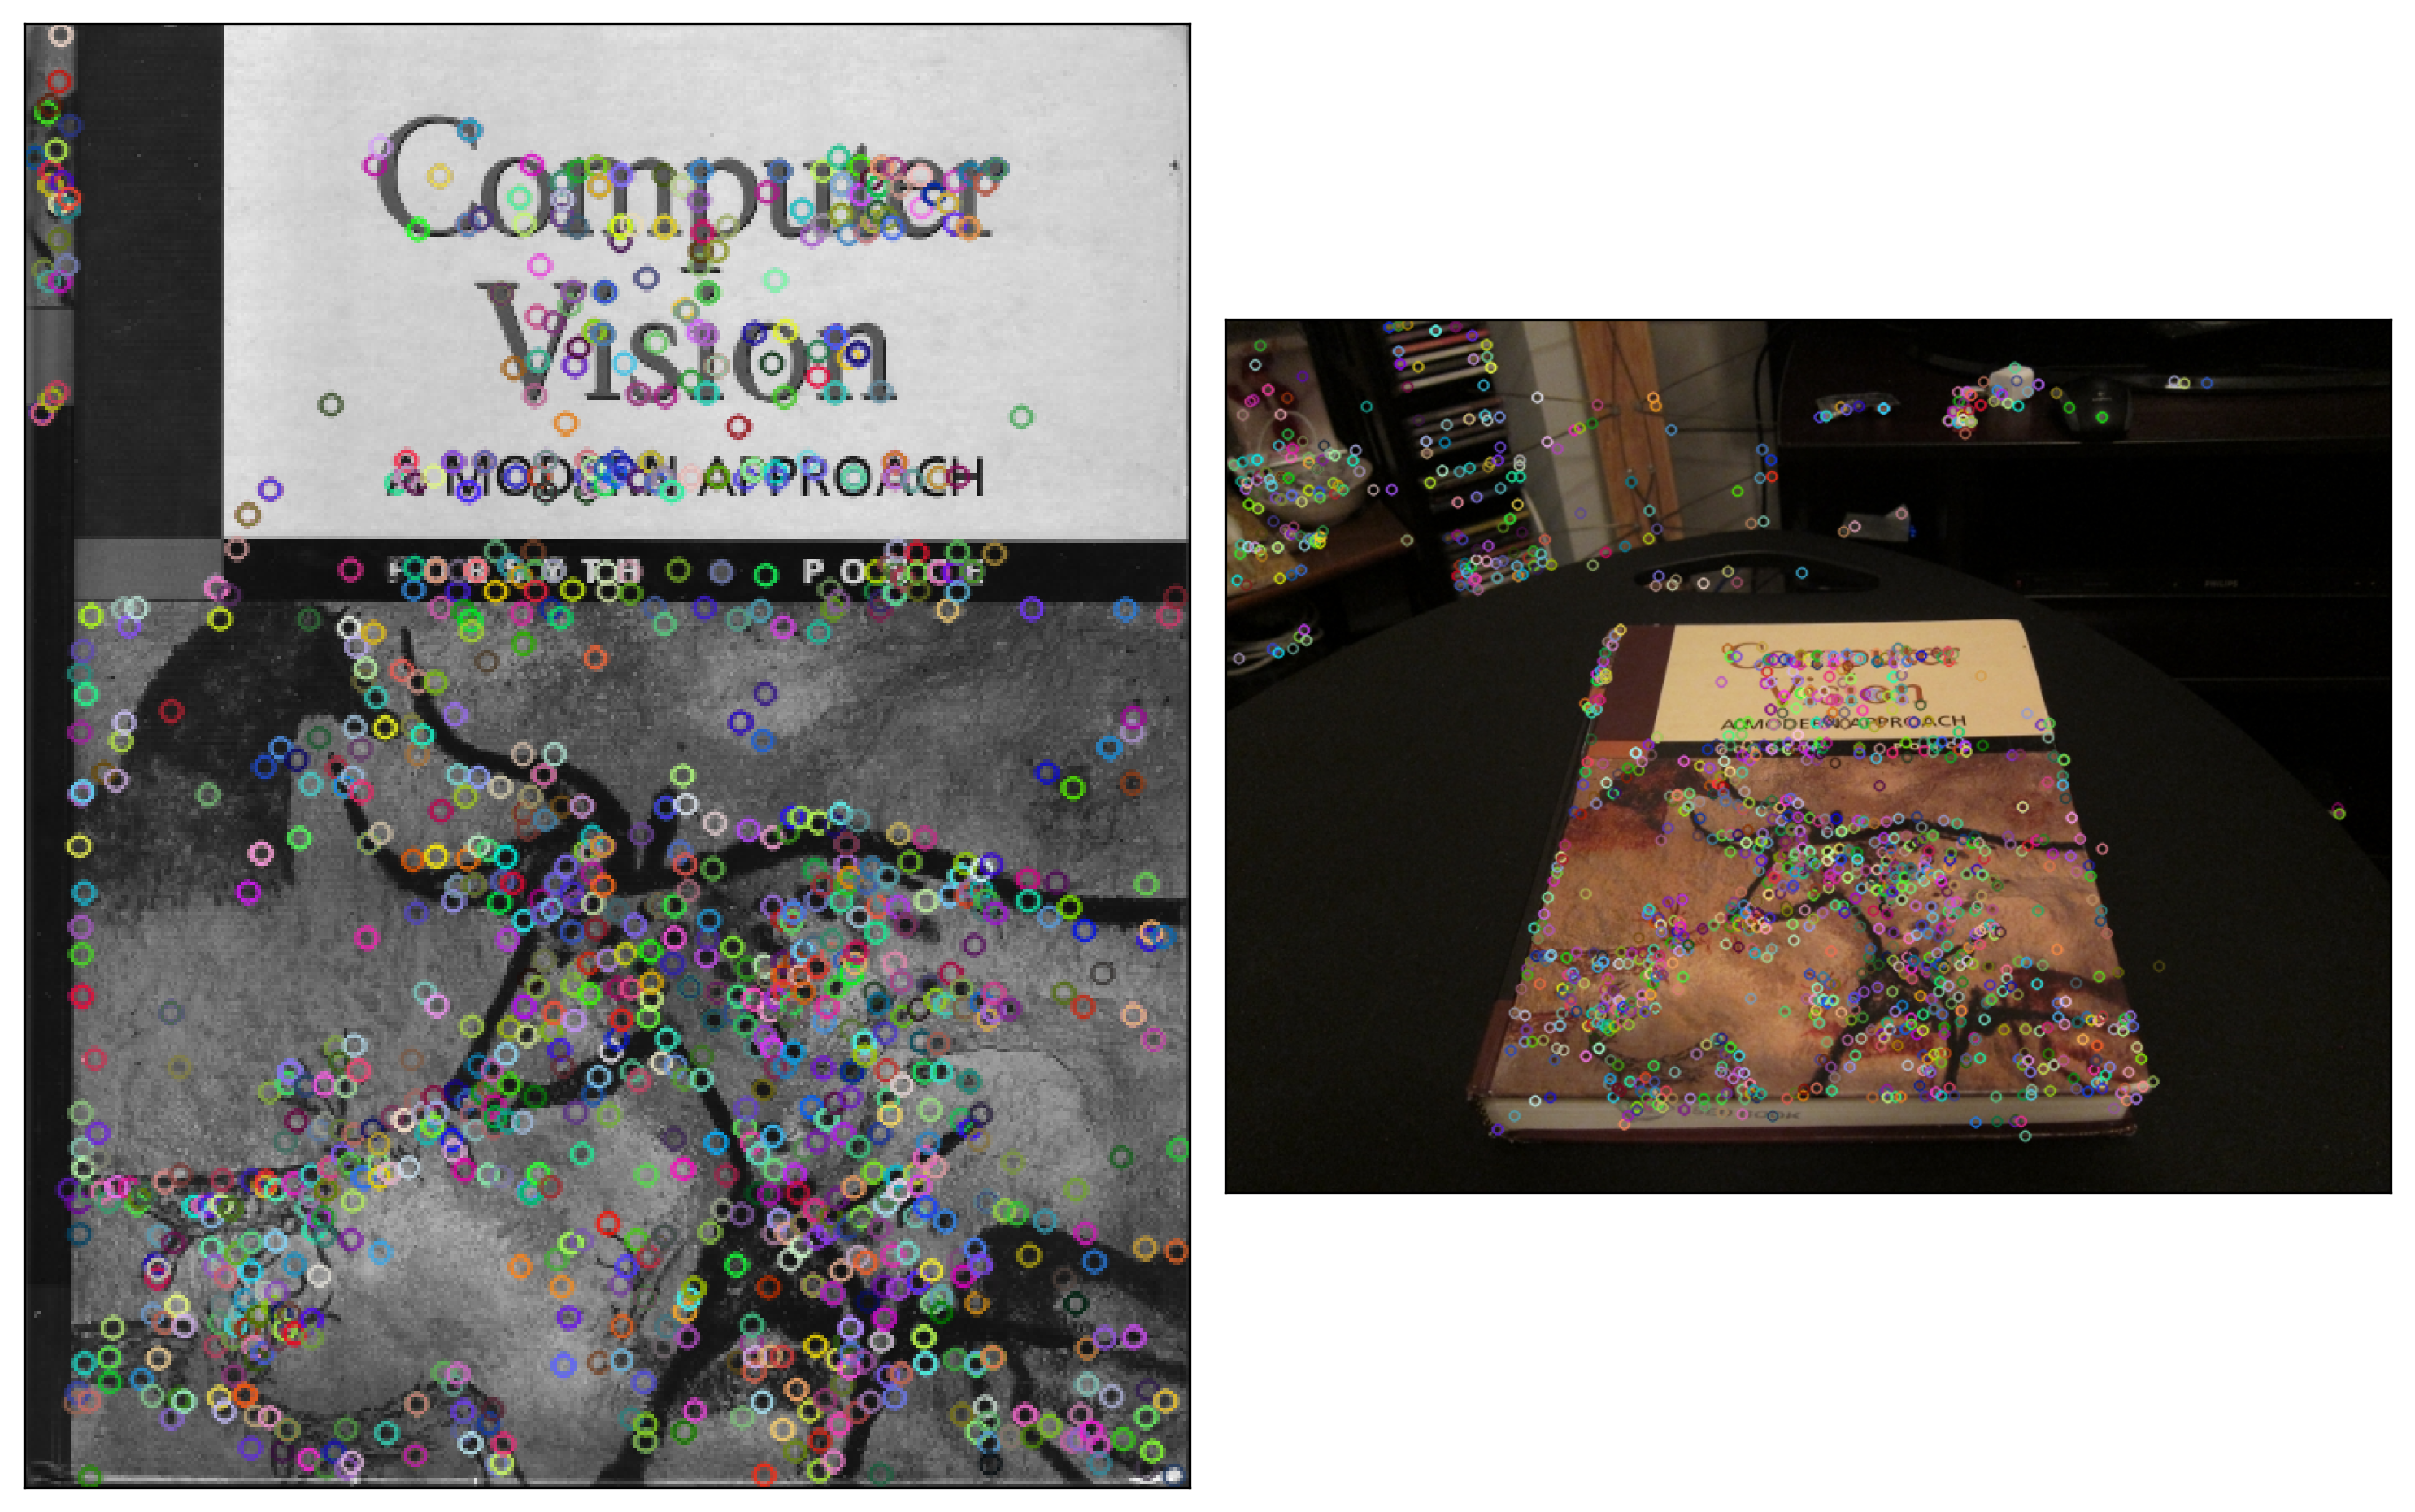

In [37]:
cover = cv.imread('assets/cv_cover.jpg', cv.IMREAD_GRAYSCALE)
desk_colored = cv.imread('assets/cv_desk.png')
desk = gray(desk_colored)

cover_kp, cover_des = detect_keypoints(cover)
desk_kp, desk_des = detect_keypoints(desk)

# Show the keypoints of the cover image and the desk image
cover_img = draw_keypoints(cover, cover_kp)
desk_img = draw_keypoints(desk_colored.copy(), desk_kp)

plot_images([cover_img, desk_img], cmap='rgb')

In [38]:
def match_keypoints(des1, des2, k):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=k)
    return matches

In [39]:
def ratio_test(matches, ratio):
    good = []
    for closest,second_closest in matches:
        if closest.distance < ratio*second_closest.distance:
            good.append(closest)
    return good

In [40]:
matches = match_keypoints(cover_des, desk_des, 2)
good_matches = ratio_test(matches, 0.5)
print("Total matches: ", len(matches))
print("Good matches: ", len(good_matches))

Total matches:  1205
Good matches:  112


In [41]:
sorted_matches = sorted(good_matches, key = lambda x:x.distance)

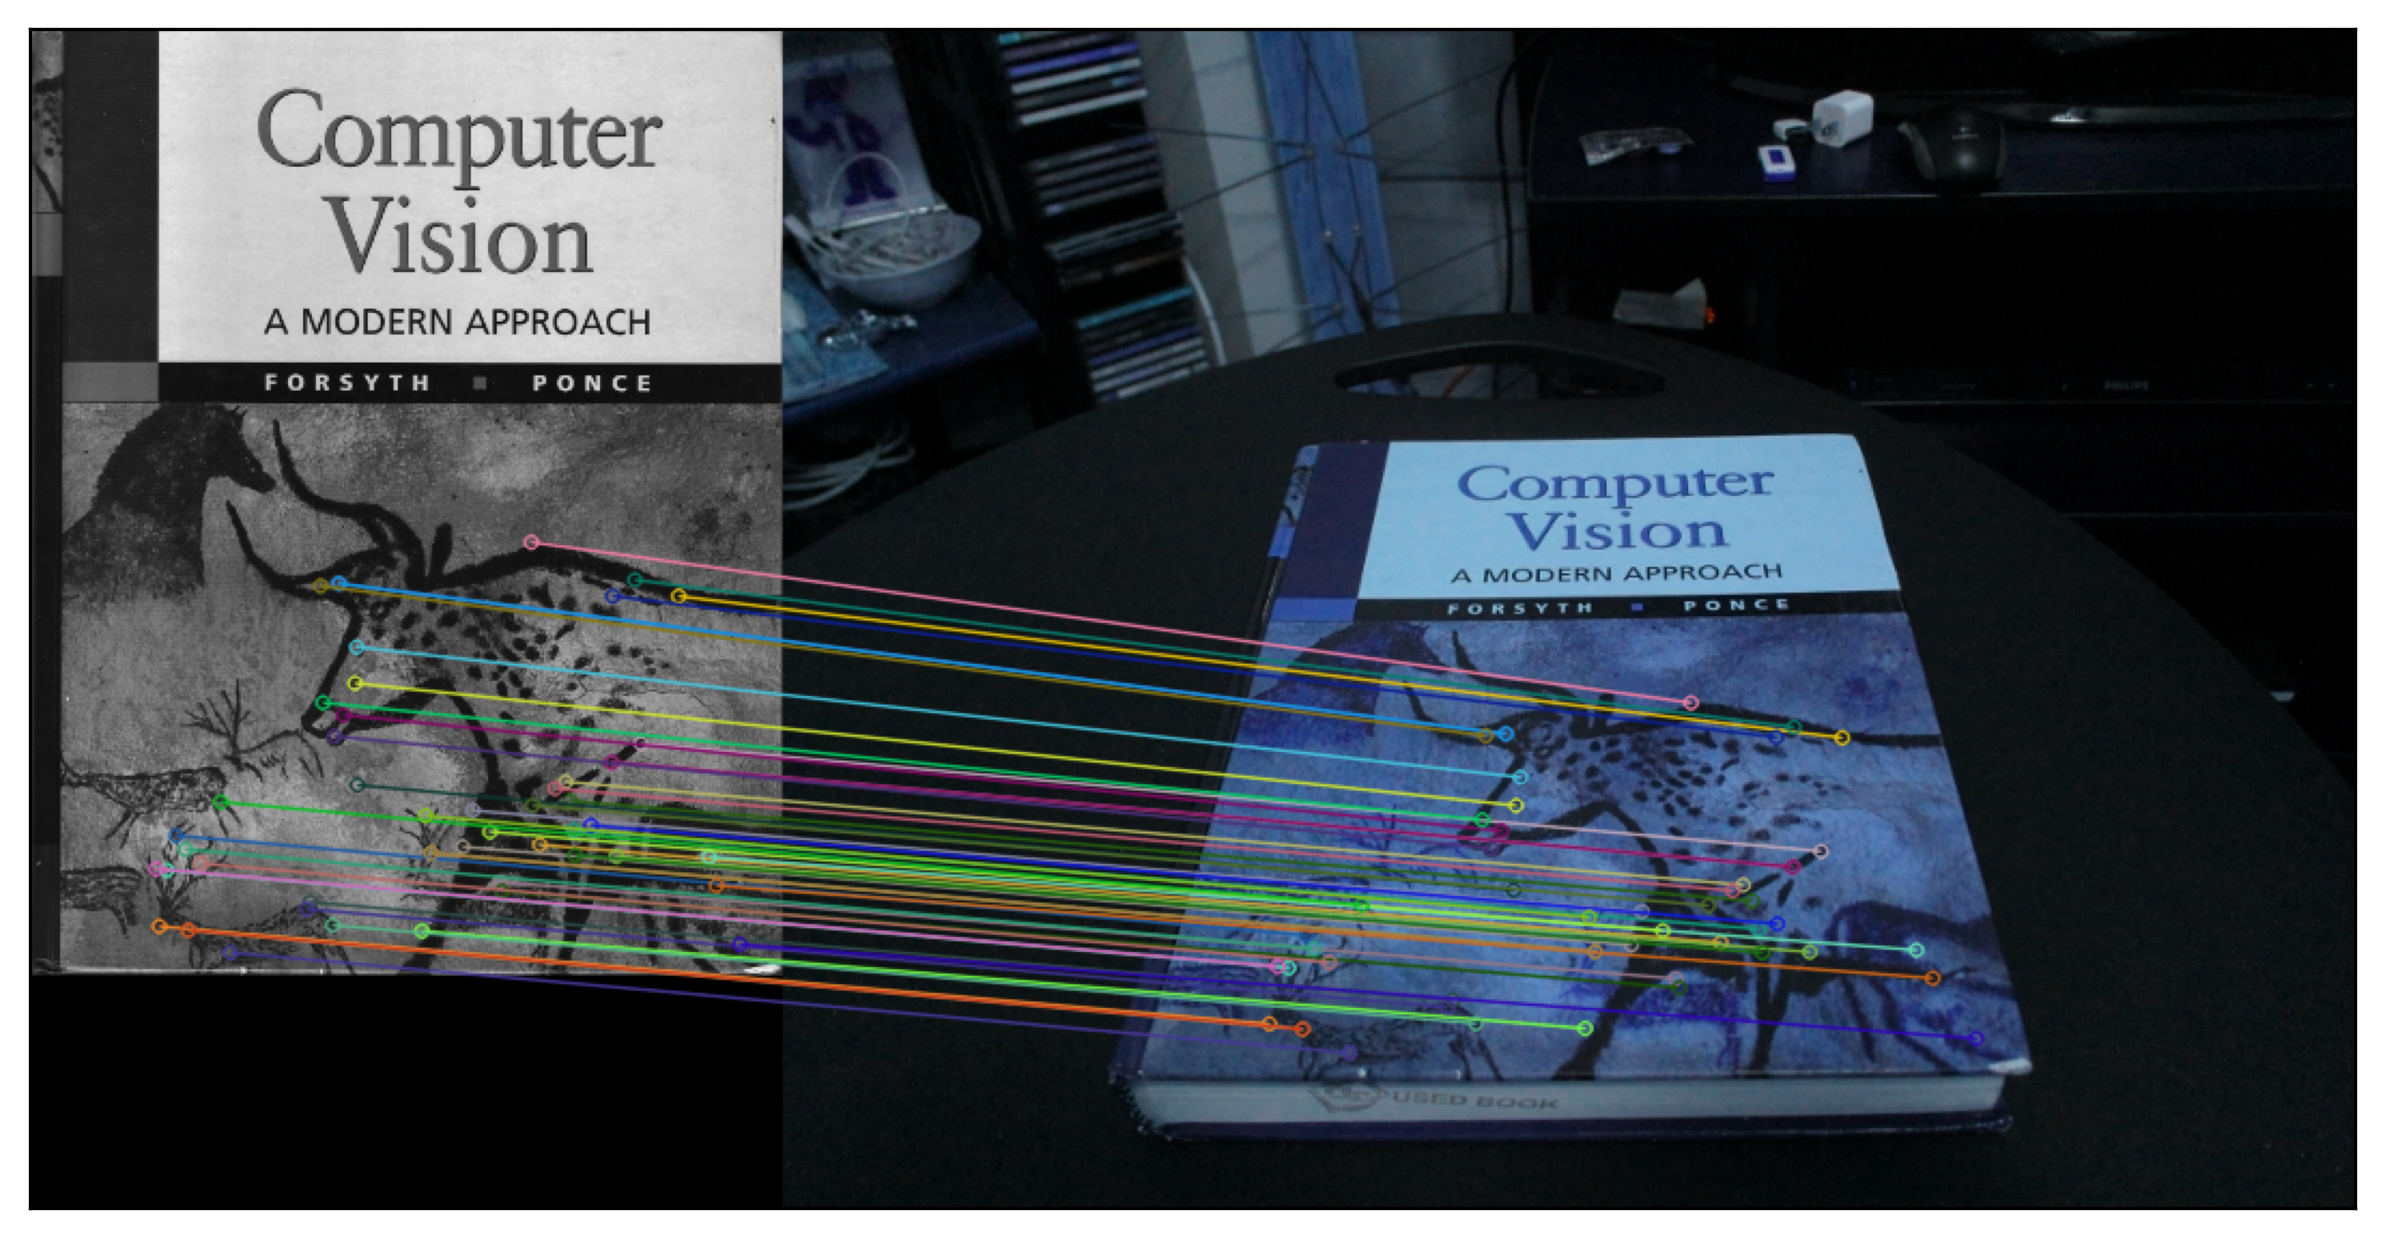

(<matplotlib.image.AxesImage at 0x25843a59b10>, None)

In [42]:
fig = plt.figure(dpi=300, figsize=(10,10))
matched_img = cv.drawMatches(cover,cover_kp,desk_colored,desk_kp,sorted_matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,)
plt.xticks([]), plt.yticks([])
plt.imshow(matched_img),plt.show()

### 1.2 Compute the Homography Parameters

In [43]:
src_pts = np.float32([cover_kp[m.queryIdx].pt for m in sorted_matches])
dst_pts = np.float32([desk_kp[m.trainIdx].pt for m in sorted_matches])

In [44]:
_x = 0
_y = 1
match_to_matrices = lambda src, dst: (
    np.array([[-src[_x], -src[_y], -1, 0, 0, 0, src[_x]*dst[_x], src[_y]*dst[_x]], [0, 0, 0, -src[_x], -src[_y], -1, src[_x]*dst[_y], src[_y]*dst[_y]]]), 
    np.array([-dst[_x], -dst[_y]])
    )

In [45]:
def compute_homography(src_pts, dst_pts):
    A = np.empty((0,8))
    B = np.empty((0,1))
    for i in range(src_pts.shape[0]):
        a, b = match_to_matrices(src_pts[i], dst_pts[i])
        A = np.append(A, a, axis=0)
        B = np.append(B, b)
    H_params = np.linalg.lstsq(A, B)[0]
    H_params = np.append(H_params, 1)
    H = H_params.reshape((3,3))
    return H

In [46]:
H = compute_homography(src_pts, dst_pts)
H

C:\Users\imoha\AppData\Local\Temp\ipykernel_47612\102375161.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_params = np.linalg.lstsq(A, B)[0]


array([[ 7.39278572e-01, -3.37324811e-01,  2.37421417e+02],
       [-1.76550585e-02,  2.34979890e-01,  1.92170096e+02],
       [-2.88452714e-05, -8.96620776e-04,  1.00000000e+00]])

In [47]:
H_inv = np.linalg.pinv(H)
H_inv

array([[ 1.34693521e+00,  4.11563775e-01, -3.98881516e+02],
       [ 4.00553593e-02,  2.46753080e+00, -4.83695630e+02],
       [ 7.47671791e-05,  2.22431105e-03,  5.54802603e-01]])

In [48]:
# Testing with a sheet example
test_src = np.array([[0,0], [0,1], [1,0], [1,1]])
test_dest = np.array([[0,0], [0.5,1], [2,0], [1.5,1]])
H_test = compute_homography(test_src, test_dest)
H_test

C:\Users\imoha\AppData\Local\Temp\ipykernel_47612\102375161.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_params = np.linalg.lstsq(A, B)[0]


array([[ 2.00000000e+00,  1.00000000e+00,  7.77156117e-16],
       [ 2.22044605e-16,  2.00000000e+00, -5.27355937e-16],
       [-4.44089210e-16,  1.00000000e+00,  1.00000000e+00]])

In [49]:
homogenous = lambda p: np.array([p[0], p[1], 1])
dehomogenous = lambda p: np.array([p[0]/p[2], p[1]/p[2]])

In [50]:
get_corresponding_point = lambda p, H: dehomogenous(np.dot(H, homogenous(p)))

### Interactive Example

In [51]:
# Function to handle mouse clicks on the first image
def cover_click(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:  # Check for left mouse button click
        print(f"Clicked on ({x}, {y})")
        cover_alt = cv.circle(cv.cvtColor(cover.copy(), cv.COLOR_GRAY2BGR), (x, y), 5, (0, 255, 0), 1)
        cv.imshow('Book Cover', cover_alt)
        point = np.array([x, y])
        point_transformed = get_corresponding_point(point, H)
        print(f"Mapped to {int(point_transformed[0])}, {int(point_transformed[1])}")
        desk_alt = cv.circle(desk_colored.copy(), (int(point_transformed[0]), int(point_transformed[1])), 5, (0, 255, 0), 1)
        cv.imshow('Desk', desk_alt)

def desk_click(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:  # Check for left mouse button click
        print(f"Clicked on ({x}, {y})")
        desk_alt = cv.circle(desk_colored.copy(), (x, y), 5, (0, 255, 0), 1)
        cv.imshow('Desk', desk_alt)
        point = np.array([x, y])
        point_transformed = get_corresponding_point(point, H_inv)
        print(f"Mapped to {int(point_transformed[0])}, {int(point_transformed[1])}")
        cover_alt = cv.circle(cv.cvtColor(cover.copy(), cv.COLOR_GRAY2BGR), (int(point_transformed[0]), int(point_transformed[1])), 5, (0, 255, 0), 1)
        cv.imshow('Book Cover', cover_alt)


# Display the first image
cv.imshow('Book Cover', cover)

# Create a window for the second image
cv.imshow('Desk', desk_colored)

# Set mouse callback function for the first image window
cv.setMouseCallback('Book Cover', cover_click)

cv.setMouseCallback('Desk', desk_click)

# Wait for any key to be pressed and then close the windows
cv.waitKey(0)
cv.destroyAllWindows()

Clicked on (343, 242)
Mapped to 145, 113


### 1.3 Calculate Book Coordinates

[[237.42141708 192.17009583]
 [146.986675   488.1381708 ]
 [584.06323289 486.03685732]
 [501.22924992 187.88771056]]


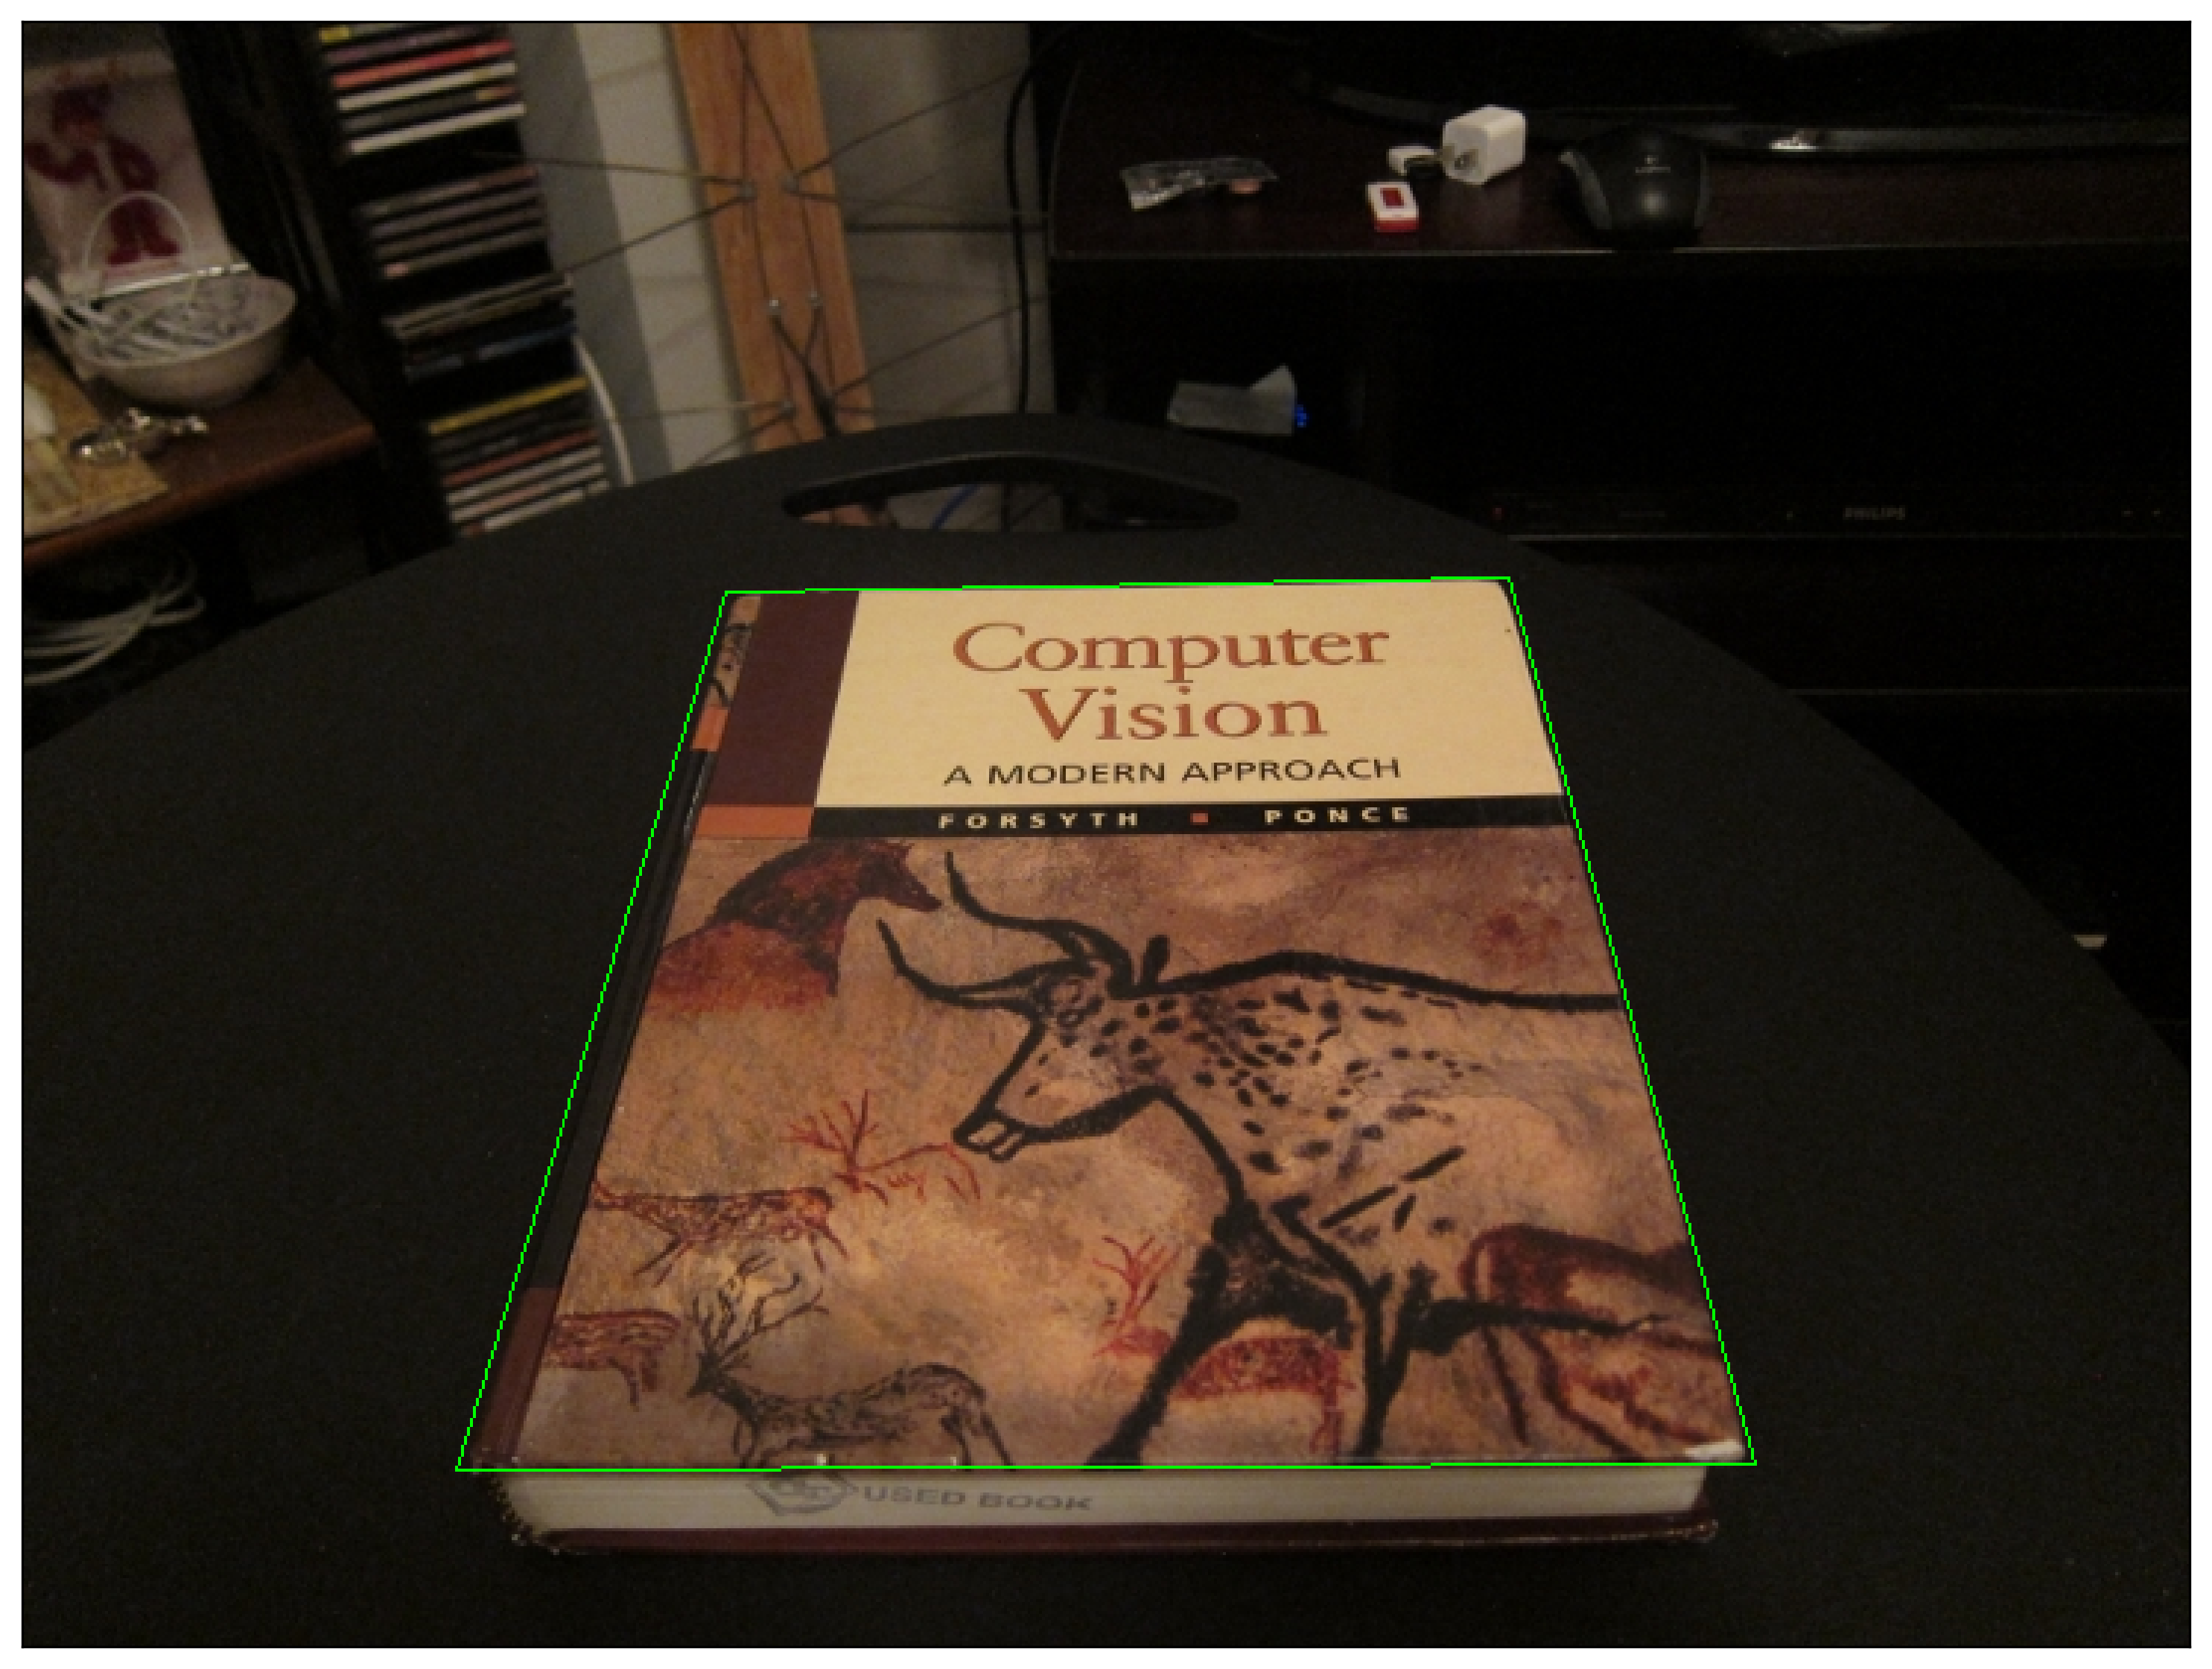

In [52]:
## Get the corners of the cover image
cover_corners = np.array([
    homogenous([0,0]),
    homogenous([0, cover.shape[0]]),
    homogenous([cover.shape[1], cover.shape[0]]),
    homogenous([cover.shape[1], 0]),
])

## Get corresponding corners of the cover in the desk image
corresponding_corners = np.array([get_corresponding_point(p, H) for p in cover_corners])

print(corresponding_corners)

desk_with_cover_corners = cv.polylines(desk_colored.copy(), [np.int32(corresponding_corners)], 1, (0, 255, 0))
    
plot_images([desk_with_cover_corners], cmap='rgb')

### 1.4 Crop AR Video Frames

In [53]:
aspect_ratio = lambda p: (p[0]//np.gcd(p[0], p[1]), p[1]//np.gcd(p[0], p[1]))

In [54]:
def crop_aspect_ratio(img, ratio):
    print(f"Original dimensions {img.shape[:2]}")
    height, width = img.shape[:2]
    new_width = int(height*ratio[1]/ratio[0])
    new_height = int(width*ratio[0]/ratio[1])
    if new_width > width:
        new_width = width
    if new_height > height:
        new_height = height
    x = (width - new_width)//2
    y = (height - new_height)//2
    res = img[y:y+new_height, x:x+new_width]
    print(f"New dimensions {res.shape[:2]}")
    return res

In [55]:
cover_aspect_ratio = aspect_ratio(cover.shape)
cropped_desk = crop_aspect_ratio(desk, cover_aspect_ratio)
print(f"Original aspect ratio: {cover_aspect_ratio[1]/cover_aspect_ratio[0]}")
print(f"New aspect ratio: {cropped_desk.shape[1]/cropped_desk.shape[0]}")

Original dimensions (548, 731)
New dimensions (548, 435)
Original aspect ratio: 0.7954545454545454
New aspect ratio: 0.7937956204379562


### Homography Class

In [56]:
class Homography:
    def __init__(self, src, dest, k=2, ratio=0.5):
        src_kp, src_des = detect_keypoints(src)
        dest_kp, dest_des = detect_keypoints(dest)
        matches = match_keypoints(src_des, dest_des, k)
        good_matches = ratio_test(matches, ratio)
        sorted_matches = sorted(good_matches, key = lambda x:x.distance)
        src_pts = np.float32([src_kp[m.queryIdx].pt for m in sorted_matches])
        dst_pts = np.float32([dest_kp[m.trainIdx].pt for m in sorted_matches])
        self.H = compute_homography(src_pts, dst_pts)
        self.H_inv = np.linalg.pinv(self.H)
        self.warp_size = (dest.shape[1], dest.shape[0])
    
    def transform(self, points):
        return np.array([get_corresponding_point(p, self.H) for p in points]).astype(int)
    
    def transform_inverse(self, points):
        return np.array([get_corresponding_point(p, self.H_inv) for p in points])
    
    def warp(self, img):
        return cv.warpPerspective(img, self.H, self.warp_size)
    
    def get_corners(self, img):
        return self.transform(np.array([
            homogenous([0,0]),
            homogenous([0, img.shape[0]]),
            homogenous([img.shape[1], img.shape[0]]),
            homogenous([img.shape[1], 0]),
        ]))

### 1.5 Overlay the First Frame of the Two Videos

Original dimensions (720, 1280)
New dimensions (720, 572)


C:\Users\imoha\AppData\Local\Temp\ipykernel_47612\102375161.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_params = np.linalg.lstsq(A, B)[0]


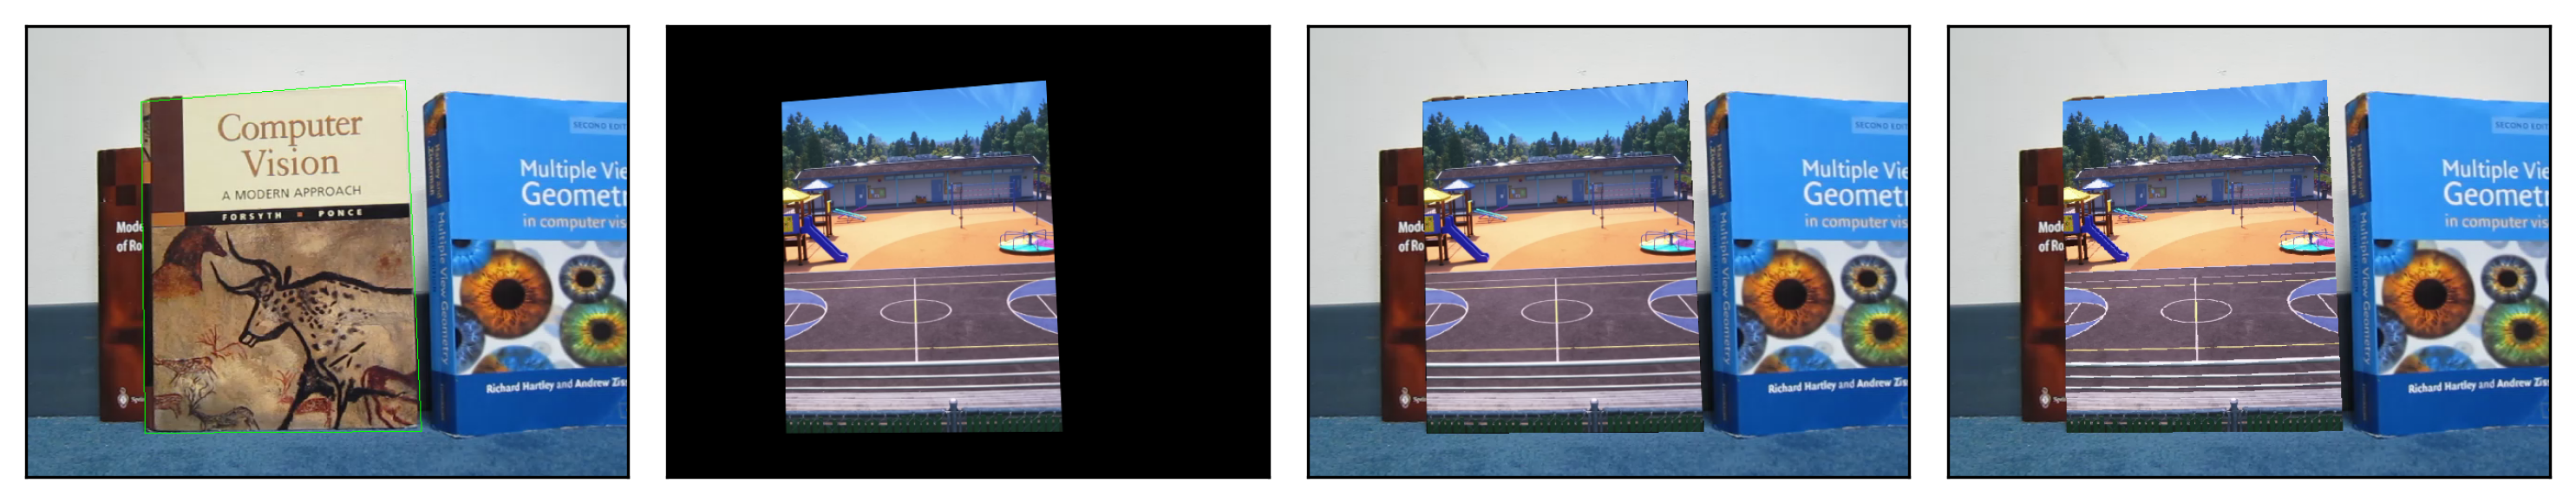

In [57]:
src_video = cv.VideoCapture('assets/ar_source.mov')
dst_video = cv.VideoCapture('assets/book.mov')

src_ret, src_frame = src_video.read()
dst_read, dst_frame = dst_video.read()

homography = Homography(cover, gray(dst_frame.copy()))

dst_with_cover_corners = cv.polylines(dst_frame.copy(), [np.int32(homography.get_corners(cover.copy()))], 1, (0, 255, 0))

cropped_src = crop_aspect_ratio(src_frame, cover_aspect_ratio)
cropped_src = cv.resize(cropped_src, cover.shape[:2][::-1])

warpped_src = homography.warp(cropped_src)

warpped_merged_frame = dst_frame.copy()
for x in range(warpped_src.shape[1]):
    for y in range(warpped_src.shape[0]):
        if np.sum(warpped_src[y,x]) > 0:
            warpped_merged_frame[y,x] = warpped_src[y,x]

merged_frame = dst_frame.copy()
for y in range(cropped_src.shape[0]):
    for x in range(cropped_src.shape[1]):
        trans = homography.transform(np.array([[x,y]]))[0]
        if(trans[0] < merged_frame.shape[1] and trans[1] < merged_frame.shape[0]):
            merged_frame[trans[1],trans[0]] = cropped_src[y,x]

plot_images([dst_with_cover_corners, warpped_src, warpped_merged_frame, merged_frame], cmap='rgb')

### 1.6 Creating AR Application

In [58]:
import time

In [59]:
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(f'out/output-cover-{time.time()}.avi', fourcc, dst_video.get(cv.CAP_PROP_FPS), dst_frame.shape[:2][::-1])

while src_ret and dst_read:
    cropped_src = crop_aspect_ratio(src_frame, cover_aspect_ratio)
    cropped_src = cv.resize(cropped_src, cover.shape[:2][::-1])
    
    homography = Homography(cover, gray(dst_frame), ratio=0.35)
    
    merged_frame = dst_frame.copy()
    for y in range(cropped_src.shape[0]):
        for x in range(cropped_src.shape[1]):
            trans = homography.transform(np.array([[x,y]]))[0]
            if(trans[0] < merged_frame.shape[1] and trans[1] < merged_frame.shape[0] and trans[0] > 0 and trans[1]):
                merged_frame[trans[1],trans[0]] = cropped_src[y,x]
    
    out.write(merged_frame)
    
    src_ret, src_frame = src_video.read()
    dst_read, dst_frame = dst_video.read()

out.release()
src_video.release()
dst_video.release()

Original dimensions (720, 1280)
New dimensions (720, 572)


C:\Users\imoha\AppData\Local\Temp\ipykernel_47612\102375161.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_params = np.linalg.lstsq(A, B)[0]


Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimensions (720, 1280)
New dimensions (720, 572)
Original dimen